# Assignment 1: Network Science

_Course: 02805 - **Social Graphs and Interactions**_ <br>
_Course responsible: **Sune Lehmann Jørgensen**_ <br>
_DTU - **Technical University of Denmark**_

---

## Table of Contents:

- [__Part 1: Binning degree distributions__](#1.)

    - [1.1. <u>Binning real numbers</u>](#1.1.)
    - [1.2. <u>Binning integers</u>](#1.2.)
    - [1.3. <u>Binning and plotting degree distributions</u>](#1.3.)


- [__Part 2: Random networks and plotting in 'networkx'__](#2.)

    - [2.1. <u>Erdős-Rényi Networks (exercise 3.1.)</u>](#2.1.)
    - [2.2. <u>Paths in Random Networks</u>](#2.2.)


- [__Part 3: Watts-Strogatz Networks__](#3.)


- [__Part 4: The Barabasi-Albert Model__](#4.)


- [__Part 5: Power-laws and the friendship paradox__](#5.)

---

#### Importing the necessary libraries:

In [1]:
import networkx as nx
import matplotlib.pyplot as plt
import numpy as np
import random
import math

%matplotlib inline

<a id='1.'></a>
## Part 1: Binning degree distributions

<a id='1.1.'></a>
### 1.1. Binning real numbers

* Use the `random` library generate 5000 data points from a Gaussian distribution with $\mu = 2$ and $\sigma = 0.125$.

In [2]:
mu, sigma = 2, 0.125
random_normal = np.random.normal(mu, sigma, size=5000)

* Use `numpy.histogram` to bin those number into 10 bins. What does the `numpy.histogram` function return? Do the two arrays have the same length?

In [3]:
hist_normal, bin_edges_normal = np.histogram(random_normal, bins=10)
print('The count of elements in each bin (hist):\n{}\n'.format(hist_normal))
print('Intervals of numbers (bin_edges):\n', bin_edges_normal)

print('\nLength of hist:', len(hist_normal))
print('Length of bin_edges:', len(bin_edges_normal))

The count of elements in each bin (hist):
[  18  100  374  926 1311 1298  686  247   36    4]

Intervals of numbers (bin_edges):
 [1.57550806 1.66400354 1.75249903 1.84099452 1.92949    2.01798549
 2.10648098 2.19497646 2.28347195 2.37196743 2.46046292]

Length of hist: 10
Length of bin_edges: 11


* Use `matplotlib.pyplot.plot` to plot the binned data. You will have to deal with the fact that the counts- and bin-arrays have different lengths. Explain how you deal with this problem and why.

> Bin edges represents the boundary of each range, hence the amount of bin edges will always be 1 more than the amount of bar groups. In order to plot them together, we can insert the very first count value into the original bar group, then the first bar which is located in between the first and the second range point would be included as well.

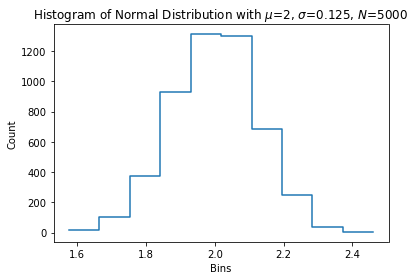

In [4]:
plt.plot(bin_edges_normal, np.insert(hist_normal, 0, hist_normal[0]), drawstyle='steps')
plt.xlabel('Bins')
plt.ylabel('Count')
plt.title('Histogram of Normal Distribution with $\mu$=2, $\sigma$=0.125, $N$=5000')
plt.show()

<a id='1.2.'></a>
### 1.2. Binning integers

* Use `numpy.random.poisson` to generate 5000 numbers drawn from a Poisson distribution characterized by $\lambda = 10$. Find the maximum and minimum value of your 5000 random numbers. 

In [5]:
lam, size = 10, 5000
random_poisson = np.random.poisson(lam=lam, size=size)
print('Max value: {}\nMin value: {}'.format(random_poisson.max(), random_poisson.min()))

Max value: 23
Min value: 1


* Create a vector $v$ that results in a binning that puts each integer value in its own bin and where the first bin contains the minimum number you found above, and the last bin contains the maximum number (you may want to think about how `numpy.histogram` deals with the smallest and largest value in particular; is it correct to set the first entry of $v$ to be equal to the smallest value you observe and the last entry of $v$ to be the highest value observed?). Use the vector by setting `numpy.histogram`'s `bin` parameter as `bin = ` $v$. 

In [6]:
v = np.unique(random_poisson).tolist()
v.append(v[-1]+1)

In [7]:
hist_poisson, bin_edges_poisson = np.histogram(random_poisson, bins=v)

* What is the sum over bin counts?

In [8]:
counts = []
for i in v[:-1]:
    # Calculate the frequency that each bin occurs
    c = sum(random_poisson==i)
    counts.append(c)
print('Sum over bin counts (manual count):')
print(counts)

Sum over bin counts (manual count):
[2, 17, 47, 101, 191, 299, 450, 595, 582, 633, 560, 468, 397, 247, 167, 107, 71, 29, 17, 8, 7, 2, 3]


*  Explain how the binning-vectors first and last element relates to the min and max from the Poisson distribution.

> Since `np.histogram` treats bins input as bin edge values, which means in order to obtain the right frequency distribution of the bins, we need to define the binning vector so that the first and last bin wanted do not end up being edges. It is discovered after experimentations that by adding an extra value after the maximum bin value element in the binning vector, the np.histogram will ouput the right distribution ready to be plotted. Therefore, the first element of the binning vector $v$ is equal to the minimum value of the poisson distribution but the last element of the binning vector is 1 larger than the maximum value of the poisson distribution.

> Note: _It will also work by adding extra element before the minimum bin value and after the maximum bin value, however that gave the exact same result as just by adding an extra element after the maximum bin value._
    

In [9]:
print('First element of binning vector: {}, min value from Poisson distribution: {}'.format(v[0], random_poisson.min()))
print('Last element of binning vector: {}, max value from Poisson distribution: {}'.format(v[-1], random_poisson.max()))

First element of binning vector: 1, min value from Poisson distribution: 1
Last element of binning vector: 24, max value from Poisson distribution: 23


  * Use a bar chart (`matplotlib.pyplot.bar`) to plot the distribution 

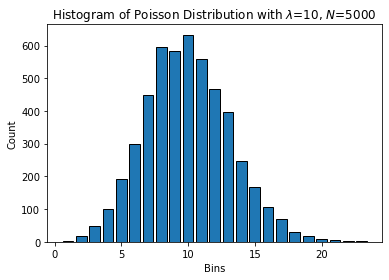

In [10]:
plt.bar(bin_edges_poisson[:-1], hist_poisson, edgecolor='black')
plt.xlabel('Bins')
plt.ylabel('Count')
plt.title('Histogram of Poisson Distribution with $\lambda$=10, $N$=5000')
plt.show()

<a id='1.3.'></a>
### 1.3. Binning and plotting degree distributions

* Generate the Erdös-Renyi (ER) network which has a degree distribution that matches the Poisson distribution above. First we have to figure out which values the ER parameters (_N_ and _p_) should assume. It's easy to see that $N = 5000$, but how do you find $p$? 

> $\because \lambda$ corresponds to <$k$\> (average degree), and  <$k$\> $ = p(N-1)$  
$\therefore  p = \frac{<k>}{N-1} $

In [11]:
N = 5000
k = 10
p = k/(N-1)

* Use `networkx` to create the graph and extract the degree distribution.

In [12]:
ER_G = nx.generators.random_graphs.erdos_renyi_graph(n=N, p=p)

* Create a bar plot of the degree distribution, including axes labels and a plot title. Make sure that it looks like the Poisson distribution you plotted above.

In [13]:
# Extract the value of degree
ER_G_degree = [v for k, v in ER_G.degree()]

# Create binning vector
v = np.unique(ER_G_degree).tolist()
v.append(v[-1]+1)

# Generate the histogram
hist_ER, bin_edges_ER = np.histogram(ER_G_degree, bins=v)

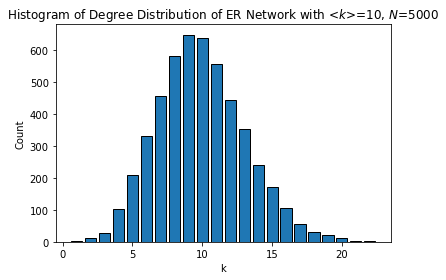

In [14]:
plt.bar(bin_edges_ER[:-1], hist_ER, edgecolor='black')
plt.xlabel('k')
plt.ylabel('Count')
plt.title('Histogram of Degree Distribution of ER Network with <$k$>=10, $N$=5000')
plt.show()

---
<a id='2.'></a>
## Part 2: Random networks and plotting in `networkx`

<a id='2.1.'></a>
### 2.1. Erdős-Rényi Networks (exercise 3.1.)

Consider an Erdős-Rényi network with $N$ = 3000 nodes, connected to each other with probability $p = 10^{-3}$.

* __a. What is the expected number of links, <$L$\>?__

> <$L$\> = $\frac{pN(N-1)}{2}$
       = 4498.5

* __b. In which regime is the network?__

> $\because p > \frac{1}{N}$ and $p \leq \frac{lnN}{N}$：  
  $\therefore$ The network is in supercritical regime

* __c. Calculate the probability $p_c$ so that the network is at the critical point.__

> $\because$ When the network is at the critical point, <$k$\> = 1  
  Also <$k$\> = $p(N-1)$  
  $\therefore p_c= \frac{<k>}{N-1} = \frac{1}{3000-1} \approx 0.000333444$

* __d. Given the linking probability $p = 10^{–3}$, calculate the number of nodes $N^{cr}$ so that the network has only one component.__

> $\because$ The network has only one component means that all the nodes are linked  
  $\therefore$ The network is in connected regime, and $p > \frac{ln(N)}{N-1}$   
  Solving for the inequality (in Maple) we obtain $0 < N^{cr} < 1$ or $N^{cr} > 9119$

* __e. For the network in (d), calculate the average degree <$k^{cr}$\> and the average distance between two randomly chosen nodes <$d$\>.__

> $\because$ In (d), the range of $N$ is: $0 < N^{cr} < 1$ or $N^{cr} > 9119$  
> $\therefore$ We will choose $N=9120$ (which is the lowest integer that satisfies the inequality) for computing average degree and average distance

In [15]:
N = 9120
p = 10**(-3)
k_cr = p*(N-1)
d = np.log(N)/np.log(k_cr)
print('Average degree k:\n{}\n\nAverage distance <d>:\n{}'.format(k_cr, d))

Average degree k:
9.119

Average distance <d>:
4.12522144293705


* __f. Calculate the degree distribution $p^k$ of this network (approximate with a Poisson degree distribution).__

> Using Poisson distribution to approximate the degree distribution, we know:  
$p_{k}=e^{-\langle k\rangle}\frac{\langle k\rangle^{k}}{k !}$,  <$k$> = 9.119 (N=9120)

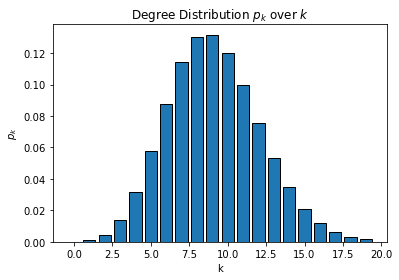

In [16]:
# Average degree is around 9, choose (0, 20) to expect a somewhat symmetric Poisson distribution
k_list = range(0, 20)

# Calculate probability of Poisson distribution
p_k = [math.exp(-k_cr)*(k_cr**k)/math.factorial(k) for k in k_list]
plt.bar(k_list, p_k, edgecolor='black')
plt.xlabel('k')
plt.ylabel('$p_k$')
plt.title('Degree Distribution $p_k$ over $k$')
plt.show()

<a id='2.2.'></a>
### 2.2. Paths in Random Networks

* Plot a random network with 200 nodes and an average degree of 1.5\. (I suggest using `networkx.draw` and reading [the documentation](https://networkx.github.io/documentation/stable/reference/drawing.html) carefully to get an overview of all the options and what they look like. For example, you may want to shrink the node size).

In [17]:
# Number of nodes
N = 200
# Average degree
k = 1.5

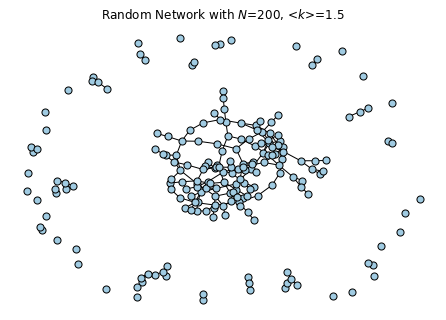

In [18]:
G = nx.generators.random_graphs.erdos_renyi_graph(n=N, p=k/(N-1))
nx.draw(G, node_size=50, node_color='#A0CBE2', edgecolors='black')
plt.title('Random Network with $N$=200, <$k$>=1.5')
plt.show()

* Extract the Giant Connected Component, GCC.

In [19]:
# Largest component
largest_cc = max(nx.connected_components(G), key=len)
GCC = G.subgraph(largest_cc).copy()

* Choose a node at random from the GCC.

In [20]:
source = random.choice(list(GCC.nodes))

* Find all nodes that are precisely 2 steps away from that node. 
* (Plot the GCC with the following choice of colors. Starting node _black_ (`"#000000"`). The nodes 2 steps away _red_ (`"#ff0000"`). All other nodes _blue_ (`"#A0CBE2"`).)

In [21]:
dist = nx.single_source_shortest_path_length(GCC, source=source, cutoff=2) 

In [22]:
colornode = []
for (k, d) in dist.items():
    if d == 2:
        colornode.append(k)

In [23]:
color_map = []
for node in GCC:
    if node == source:
        color_map.append('#000000')
    elif node in colornode: 
        color_map.append('#ff0000')    
    else:
        color_map.append('#A0CBE2')

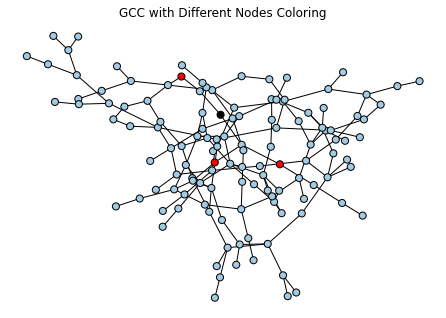

In [24]:
nx.draw(GCC, node_size=50, node_color=color_map, edgecolors='black')
plt.title('GCC with Different Nodes Coloring')
plt.show()

---
<a id='3.'></a>
## Part 3: Watts-Strogatz Networks

* Use `nx.watts_strogatz_graph` to generate 3 graphs with 500 nodes each, average degree = 4, and rewiring probablity $p = 0, 0.1, \textrm{and} 1$. 

> The three graphs specified are generated below, using the properties of $N$ for number of nodes, $k$ for the average degree of a node, and $p$ for the rewiring probability of a node:

In [25]:
# Number of nodes
N = 500
# Average degree
k = 4
# List of rewiring probability
p_list = [0, 0.1, 1]

In [26]:
WS_G_p_0 = nx.watts_strogatz_graph(n=N, k=k, p=p_list[0])
WS_G_p_01 = nx.watts_strogatz_graph(n=N, k=k, p=p_list[1])
WS_G_p_1 = nx.watts_strogatz_graph(n=N, k=k, p=p_list[2])

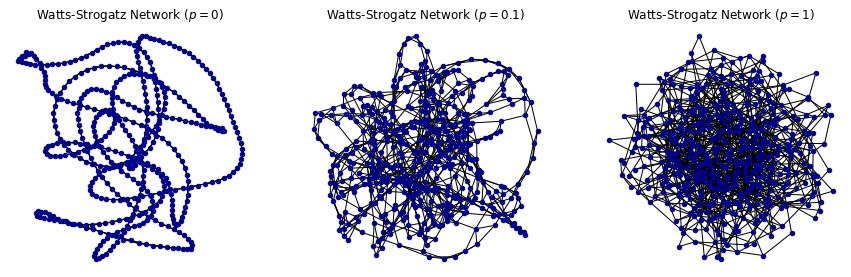

In [27]:
plt.figure(figsize = [15, 4.5])

# p=0
plt.subplot(1, 3, 1)
plt.title('Watts-Strogatz Network ($p = 0$)')
nx.draw(WS_G_p_0, node_size=20, node_color='darkblue')

# p=0.1
plt.subplot(1, 3, 2)
plt.title('Watts-Strogatz Network ($p = 0.1$)')
nx.draw(WS_G_p_01, node_size=20, node_color='darkblue')

# p=1
plt.subplot(1, 3, 3)
plt.title('Watts-Strogatz Network ($p = 1$)')
nx.draw(WS_G_p_1, node_size=20, node_color='darkblue')

> The three graphs above are represented in their simple network representation, using `nx.draw()`. We can also achieve beautiful visualizations regarding the "conectedness" of such graphs using another type of plot called _shell plot_ (done using `nx.draw_shell`).  

> The same graphs represented above are re-drawn in shell format, just to demonstrate the amount of shortcuts that exists in each of these graphs. As we can see below, this amount increases as the rewiring probability $p$ increases.

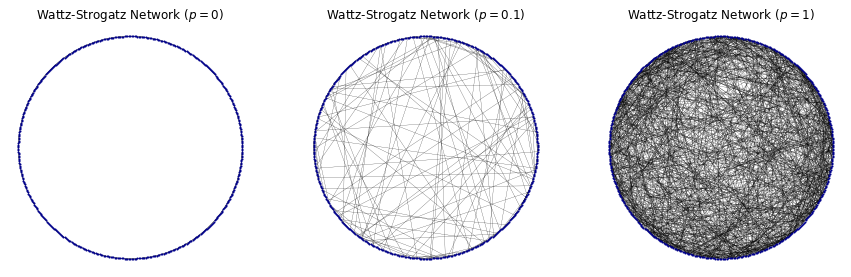

In [28]:
plt.figure(figsize = [15, 4.5])

# p=0
plt.subplot(1, 3, 1)
nx.draw_shell(WS_G_p_0, width=0.2, node_size=1, node_color='darkblue')
plt.title('Wattz-Strogatz Network ($p = 0$)');

# p=0.1
plt.subplot(1, 3, 2)
nx.draw_shell(WS_G_p_01, width=0.2, node_size=1, node_color='darkblue')
plt.title('Wattz-Strogatz Network ($p = 0.1$)');

# p=1
plt.subplot(1, 3, 3)
nx.draw_shell(WS_G_p_1, width=0.2, node_size=1, node_color='darkblue')
plt.title('Wattz-Strogatz Network ($p = 1$)');

* Calculate the average shortest path length <$d$\> for each one.

In [29]:
print('Average shortest path length for Watts-Strogatz Graph #1 (p = 0):   %.3f' % nx.average_shortest_path_length(WS_G_p_0))
print('Average shortest path length for Watts-Strogatz Graph #2 (p = 0.1): %.3f' % nx.average_shortest_path_length(WS_G_p_01))
print('Average shortest path length for Watts-Strogatz Graph #3 (p = 1):   %.3f' % nx.average_shortest_path_length(WS_G_p_1))

Average shortest path length for Watts-Strogatz Graph #1 (p = 0):   62.876
Average shortest path length for Watts-Strogatz Graph #2 (p = 0.1): 7.453
Average shortest path length for Watts-Strogatz Graph #3 (p = 1):   4.760


* Describe what happens to the network when $p = 1$.

> First of all, let us understand what the _rewiring probability_ ___$p$___ is referring to, in our Watts-Strogatz networks: <br> 
This value means the probability that an _edge_ is disconnected from one of its two nodes, and randomly connected to a separate node from the network (randomly).

> A number of these "rewired" edges will create long-distance connection paths (i.e. _shortcuts_) that facilitate interaction between nodes which are far away from each other. The more shortcuts in a network, the lower its average path length will be. As the probability ___$p$___ increases, edges are more likely to be rewired into creating random paths. 

> When ___$p = 1$___, ___every single edge in the network has been disconnected from one node and received a random node to create a path with.___ 

> Even though the paths are not fully random (since only 1 out of 2 nodes has been rewired for each edge), we can immediately see that the network resembles an __Erdős–Rényi random network__. The network will contain more random jumps, and the "shortest path length" for the network will be drastically reduced, so that on average we need between 4 and 5 node links to reach any end node from any starting node in the network.

* Let's understand the behavior of the WS model as we increase _p_ in more detail. Generate 50 networks with $N = 500$, <$k$\> $= 4$, for each of $p=\{0, 0.01, 0.03, 0.05, 0.1, 0.2\}$. Calculate the average of <$d$\> as well as the standard deviation over the 50 networks, to create a plot that shows how the path length decreases very quickly with only a little fraction of re-wiring. Use the standard deviation to add errorbars to the plot.

In [30]:
# Number of nodes
N = 500
# Average degree
k = 4
# List of rewiring probability
p_list = [0, 0.01, 0.03, 0.05, 0.1, 0.2]

In [31]:
d = {}
for p in p_list:
    d[p] = []
    for i in range(50):
        WS_G = nx.watts_strogatz_graph(n=N, k=k, p=p)
        d[p].append(nx.average_shortest_path_length(WS_G))

In [32]:
# List of mean value
d_mean = [np.mean(d[p]) for p in p_list]
# List of standard deviation
d_std = [np.std(d[p]) for p in p_list]

> The means and standard deviation, collected from our experiment, are plotted in the graph below:

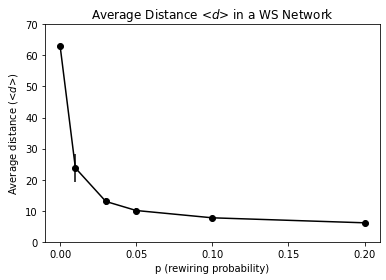

In [59]:
plt.errorbar(p_list, d_mean, yerr=d_std, color='black', marker='o')

plt.ylim(0, 70)
plt.xticks(np.arange(min(p_list), max(p_list) + 0.05, 0.05))
plt.xlabel("p (rewiring probability)")
plt.ylabel("Average distance (<$d$>)")
plt.title("Average Distance <$d$> in a WS Network")
plt.show()

> As expected, we can see that even just from $p= 0$ to $p = 0.01$ (1% rewiring probability), the path length decreases significantly, and already at $p = 0.1$ (10% rewiring probability), the average distance in the network is about 6 times smaller than without any rewiring ($p = 0$).

---
<a id='4.'></a>
## Part 4: The Barabasi-Albert Model

* Create a 100 node BA network using a BA model that you've coded on your own (so don't use the built-in function, but the one you created during week 3). And plot it using `NetworkX`.

In [34]:
# Create a Barabasi-Albert graph given a certain number of nodes
def BA_network_generator(num_of_node):
    # Start by creating a network with a single link (and 2 nodes)
    BA_G = nx.Graph()
    BA_G.add_edge(0, 1)
    
    # Create the rest of nodes, link them proportional to their degree
    for i in range(2, num_of_node):
        
        # A list containing all nodes from all edges in the network (without removing any duplicate nodes)
        nodes = list(sum(BA_G.edges(), ()))
        random_node = random.choice(nodes)
        BA_G.add_edge(i, random_node)
        
    return BA_G

In [35]:
# Create a 100-node BA network
BA_G_100 = BA_network_generator(num_of_node=100)

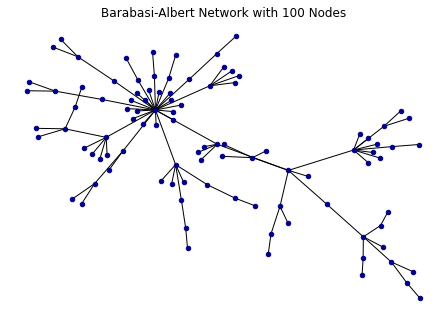

In [36]:
# Plot the 100-node BA network
nx.draw(BA_G_100, node_size=20, node_color='darkblue')
plt.title('Barabasi-Albert Network with 100 Nodes')
plt.show()

* Now create a 5000 node network.

In [37]:
# Create a 5000-node Barabasi-Albert network
BA_G_5000 = BA_network_generator(num_of_node=5000)

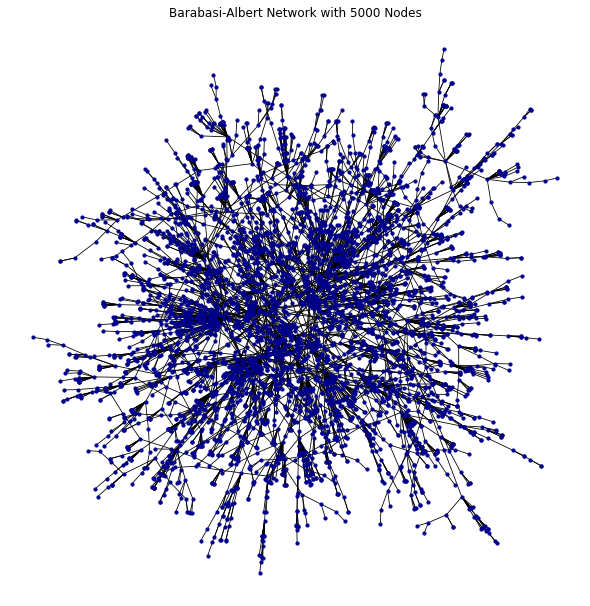

In [38]:
# Plot the 5000-nodes BA network
plt.figure(figsize=[8, 8])
nx.draw(BA_G_5000, node_size=10, width=0.8, node_color='darkblue')
plt.title('Barabasi-Albert Network with 5000 Nodes')
plt.show()

* What's the maximum and minimum degree?

In [39]:
# Build a list of degree from BA_G_5000
BA_degree = [d for (n, d) in BA_G_5000.degree()]

In [40]:
print('The maximum degree in the 5000-node Barabasi-Albert network is:', max(BA_degree))
print('The minimum degree in the 5000-node Barabasi-Albert network is:', min(BA_degree))

The maximum degree in the 5000-node Barabasi-Albert network is: 130
The minimum degree in the 5000-node Barabasi-Albert network is: 1


> __Already from here, we can illustrate that a "hub" in the network clearly exists, having a very large degree.__ 

> __Moreover, since the minimum degree in the network is 1, it means that no node is isolated in such a scenario.__ 

* Now, bin the degree distribution, for example using `numpy.histogram`.

In [55]:
bins = np.arange(min(BA_degree), max(BA_degree)+1)
hist, bin_edges = np.histogram(BA_degree, bins)

* Plot the distribution. Plot it with both linear and log-log axes.

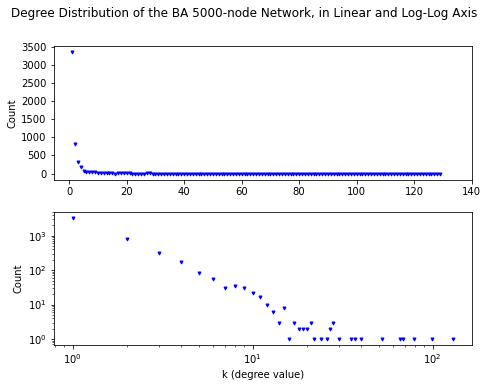

In [56]:
# Plot the distribution, with both linear and log-log axes
plt.figure(figsize = [7, 5])
plt.suptitle('Degree Distribution of the BA 5000-node Network, in Linear and Log-Log Axis')

# Plot the distribution with linear axes
plt.subplot(2, 1, 1);
plt.plot(bin_edges[:-1], hist, 'bv', markersize = 3)
plt.xticks(range(0, np.max(bin_edges[:-1]) + 20, 20))
plt.yticks(range(0, np.max(hist) + 500, 500))
plt.ylabel('Count')

# Add some small padding between the subplots
plt.tight_layout(pad = 1.5)

# Plot the distribution with log-log axes
plt.subplot(2, 1, 2);
plt.loglog(bin_edges[:-1], hist, 'bv', markersize = 3)
plt.xlabel('k (degree value)')
plt.ylabel('Count');

> __What we can clearly see from the distribution plots above is that this Barabasi-Albert model behaves according to a power-law distribution, which is a broad distribution, in terms of the degree values present in our network.__

> These results also shows that, by using *'preferential attachment'*, there will clearly be a 'hub node' in the network with a much larger degree than almost all of the other nodes.

---
<a id='5.'></a>
## Part 5: Power-laws and the friendship paradox

Next step is to explore the [Friendship paradox](https://en.wikipedia.org/wiki/Friendship_paradox). This paradox states that _almost everyone_ have fewer friends than their friends have, on average. This sounds crazy, but is actually an almost trivial consequence of living in a social network with a power-law degree distribution. The explanation is that almost everyone is friends with a hub, that drives up the average degree of the friends. Let's explore that in the 5000 node BA network we've just generated. Do the following:

* Pick a node _i_ at random (e.g. use `random.choice`). [Find its degree](http://networkx.lanl.gov/reference/generated/networkx.Graph.degree.html).

In [92]:
# Select a node at random from 5000 nodes of BA_G_5000
random_node_i = random.choice(list(BA_G_5000.nodes))

# Compute its degree
random_node_degree = BA_G_5000.degree(random_node_i)
print('The degree of a randomly-selected node (i) is:', random_node_degree)

The degree of a randomly-selected node (i) is: 2


* Find _i_'s [neighbors](http://networkx.lanl.gov/reference/generated/networkx.Graph.neighbors.html). And calculate their average degree.

In [93]:
# Find all neighbors of the random node i
random_node_i_neighbours = nx.all_neighbors(graph=BA_G_5000, node=random_node_i)

# Compute the average degrees of all the neighbours
neighbour_degrees = list(dict(BA_G_5000.degree(random_node_i_neighbours)).values())
average_neighbour_degree = np.mean(neighbour_degrees)
print('The average degree of all the neighbours of the random node (i) is:', average_neighbour_degree)

The average degree of all the neighbours of the random node (i) is: 7.0


* Compare the two numbers to check if it's true that _i_'s friends (on average) have more friends than _i_.

In [94]:
# Test the hypothesis proposed by the Friendship Paradox
if (random_node_degree < average_neighbour_degree):
    print('The friendship paradox holds!')
else:
    print('The frienship paradox was not manifested for this random node.')

The friendship paradox holds!


* Do this 1000 times. How many out of those 1000 times is the friendship paradox true?

In [95]:
def check_friendship_paradox(G, iteration):
    
    # Counter for holding the number of times where the Friendship paradox was found to be true
    fp_counter = 0
    
    for i in range(0, iteration):
        # Select a node at random from the set of 5000 nodes of the BA graph
        random_node = random.choice(list(G.nodes()))

        # Compute its degree
        random_node_degree = G.degree(random_node)
        
        # Find all neighbours of the random node (in the network)
        random_node_neighbours = nx.all_neighbors(G, random_node)

        # Compute the average of all their degrees
        neighbour_degrees = list(dict(G.degree(random_node_neighbours)).values())
        average_neighbour_degree = np.mean(neighbour_degrees)
        
        # Test the hypothesis proposed by the Friendship Paradox
        if (random_node_degree < average_neighbour_degree):
            # If the friendship paradox holds, increment the counter
            fp_counter += 1
            
    return fp_counter

> Let's use the function created above to check how many times (out of 1000 times) is the Friendship Paradox true:

In [96]:
iteration = 1000
total_fp_times = check_friendship_paradox(BA_G_5000, iteration)

print('The Friendship Paradox was observed in {}/{} trials.'.format(total_fp_times, iteration))

The Friendship Paradox was observed in 871/1000 trials.


> It seems that, often, the Friendship Paradox seems to happen for $>85\%$ of the total number of trials, meaning that this phenomenon occurs very frequently for nodes inside a network which uses preferential attachment.

* Finally, we'll build a network of same size and degree, using the growth mechanism without the preferential attachment. 
* Compare to the ER network of same size and same $p$. What are the differences? Explain in your own words. *Hint*: To get started, take a look at the degree distribution, and study the number of connected components.

> Creating an Erdos-Renyi network with the same number of nodes and the same $p$ as in Barabasi-Albert network.

In [97]:
# Number of nodes for Erdos-Renyi network
N = 5000

# 'BA_degree' was storing the degree values of all the nodes in the 'BA_G_5000' network
average_k = np.mean(BA_degree)

# Probability
p = average_k/(N - 1)

# Generate ER graph
ER_G_5000 = nx.erdos_renyi_graph(N, p)

> Just like with the Barabasi-Albert network, let us plot the network representation, in order to better understand how the connections are formed:

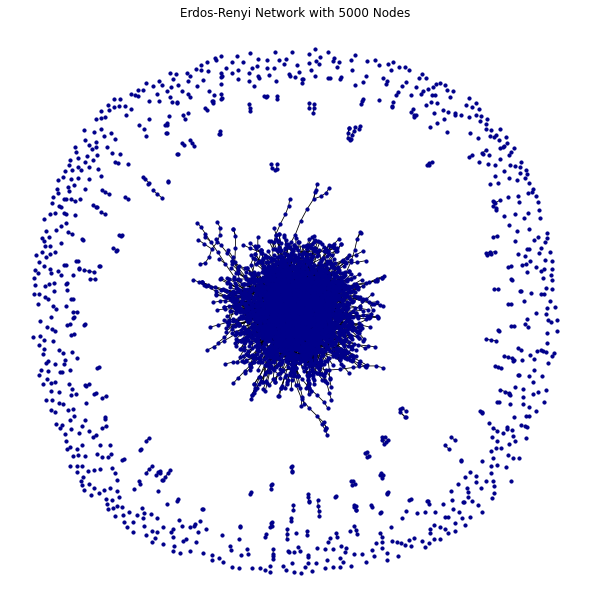

In [98]:
plt.figure(figsize=[8, 8])
nx.draw(ER_G_5000, node_size=10, width=0.8, node_color='darkblue')
plt.title('Erdos-Renyi Network with 5000 Nodes')
plt.show()

> _One immediate difference between the two types of networks is that **the ER network has a large cluster and multiple isolated nodes, whereas such a thing does not happen inside a BA network.**_  
> _**In a BA network, all network nodes belong to the main cluster, and there are no isolated nodes with degree = 0.**_ 

> Let us also check:  
> 1. The maximum and minimum degrees of the ER random network  
> 2. The distribution of degrees across a linear and log-log plot    
> (Since this is exactly what we checked for the BA network, so we have a 1-to-1 means of comparison)

In [99]:
ER_degree = [degree for (node, degree) in ER_G_5000.degree()]

print('The maximum degree in the 5000-node Erdos-Renyi network is:', max(ER_degree))
print('The minimum degree in the 5000-node Erdos-Renyi network is:', min(ER_degree))

The maximum degree in the 5000-node Erdos-Renyi network is: 9
The minimum degree in the 5000-node Erdos-Renyi network is: 0


> Already from here, we see another difference, since the minimum degree in the ER network is allowed to be $0$, whereas in the BA network, the minimum degree will be at least $1$.  
> Also, the maximum degree in this random network is __much lower__ than in our BA network, since there is no "hub" in the network.

> Check the degree distribution plots:

In [100]:
bins = np.arange(min(ER_degree), max(ER_degree)+1)
hist, bin_edges = np.histogram(ER_degree, bins)

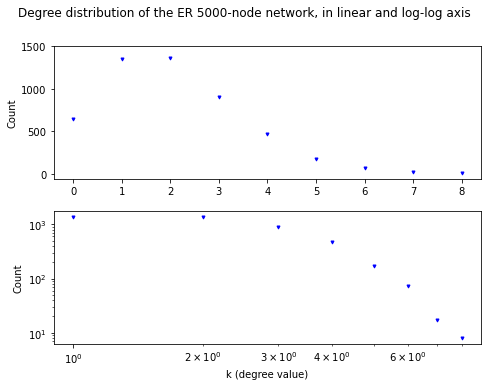

In [101]:
# Plot the distribution, with both linear and log-log axes
plt.figure(figsize = [7, 5])
plt.suptitle('Degree distribution of the ER 5000-node network, in linear and log-log axis')

# Plot the distribution with linear axes
plt.subplot(2, 1, 1);
plt.plot(bin_edges[:-1], hist, 'bv', markersize = 3)
plt.yticks(range(0, np.max(hist) + 500, 500))
plt.ylabel('Count')

# Add some small padding between the subplots
plt.tight_layout(pad = 1.5)

# Plot the distribution with log-log axes
plt.subplot(2, 1, 2);
plt.loglog(bin_edges[:-1], hist, 'bv', markersize = 3)
plt.xlabel('k (degree value)')
plt.ylabel('Count');

> Comparing these plots with the ones from the 5000-node BA network, we see some differences:
> 1. The degree variance is much higher in the case of a Barabasi-Albert network, due to the way preferential attachment works.
> 2. The Erdos-Renyi network has the degree values distributed more evenly, compared to the BA network, where most nodes had a degree of 1 (or 2), and very rare cases of degree 3 or above.

> Lastly, let us look at the number of connected components in each of these networks:

In [102]:
print('The number of connected components in the 5000-node Barabasi-Albert network is: ', nx.number_connected_components(BA_G_5000))
print('The number of connected components in the 5000-node Erdos-Renyi network is:     ', nx.number_connected_components(ER_G_5000))

The number of connected components in the 5000-node Barabasi-Albert network is:  1
The number of connected components in the 5000-node Erdos-Renyi network is:      790


> The result from checking the number of connected components is a natural conclusion to everything we have discussed so far, since:
> 1. The reason why the BA network has only 1 connected component is because of the preferential attachment mechanism, which forces all nodes to connect with another node in the network. Thus, all nodes will be connected to the single, main cluster, and there will be no isolated nodes.
> 2. The number of connected components in the ER network is very large, because the network contains a large number of isolated components or other components of 2-3 connected nodes, which are separated from the main cluster, and which drive the number of components up.